# Getting Data

## In this section i extract the data i get from app and arrange it as i can use

In [20]:
!pip install python-chess

import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [21]:
print("I upload the files in format pgn")
uploaded = files.upload()

I upload the files in format pgn


Saving chess_com_games_2025-11-25 (1).pgn to chess_com_games_2025-11-25 (1) (2).pgn
Saving chess_com_games_2025-11-25 (2).pgn to chess_com_games_2025-11-25 (2) (2).pgn
Saving chess_com_games_2025-11-25 (3).pgn to chess_com_games_2025-11-25 (3) (2).pgn
Saving chess_com_games_2025-11-25 (4).pgn to chess_com_games_2025-11-25 (4) (2).pgn
Saving chess_com_games_2025-11-25 (5).pgn to chess_com_games_2025-11-25 (5) (2).pgn
Saving chess_com_games_2025-11-25 (6).pgn to chess_com_games_2025-11-25 (6) (2).pgn
Saving chess_com_games_2025-11-25 (7).pgn to chess_com_games_2025-11-25 (7) (2).pgn
Saving chess_com_games_2025-11-25.pgn to chess_com_games_2025-11-25 (9).pgn


I am adding my USERNAME since the files i have understand my moves with that

In [22]:
MY_USERNAME = "omerusss"

# Data Preprocessing

In [23]:
def get_opening_category(first_move_uci):
    if not first_move_uci: return "Unknown"
    opening_map = {
        "e2e4": "King's Pawn Game (e4)", "d2d4": "Queen's Pawn Game (d4)",
        "c2c4": "English Opening (c4)", "g1f3": "Reti (Nf3)",
        "b2b3": "Nimzo-Larsen (b3)", "f2f4": "Bird's (f4)", "b1c3": "Van't Kruijs (Nc3)"
    }
    return opening_map.get(first_move_uci, "Uncommon Opening")

def preprocess_all_games(uploaded_files, target_username):
    data = []

    for filename, content in uploaded_files.items():
        print(f"Preprocessing {filename}... (This might take a moment)")
        pgn = io.StringIO(content.decode('utf-8'))

        while True:
            game = chess.pgn.read_game(pgn)
            if game is None: break

            headers = game.headers
            white = headers.get("White", "Unknown")
            black = headers.get("Black", "Unknown")

            # 1. Identity Check
            if target_username in white:
                user_color = chess.WHITE
            elif target_username in black:
                user_color = chess.BLACK
            else:
                continue

            # 2. Fix Opening Name
            opening_name = headers.get("Opening", "Unknown")
            if opening_name in ["Unknown", "?"]:
                first_move = None
                for move in game.mainline_moves():
                    first_move = move.uci()
                    break
                opening_name = get_opening_category(first_move)

            # 3. The "Deep Dive" Loop (Aggression, Mobility, Queen)
            board = game.board()

            # Trackers
            queen_move_number = None
            aggressive_moves = 0  # Checks + Captures
            my_move_count = 0
            mobility_sum = 0      # Sum of legal moves available

            for move in game.mainline_moves():
                # --- BEFORE THE MOVE (Check Options) ---
                if board.turn == user_color:
                    my_move_count += 1

                    # Mobility: How many choices do I have right now?
                    mobility_sum += board.legal_moves.count()

                    # Queen Dev: Is this my Queen moving for the first time?
                    if queen_move_number is None:
                        piece = board.piece_at(move.from_square)
                        if piece and piece.piece_type == chess.QUEEN and piece.color == user_color:
                            queen_move_number = board.fullmove_number

                    # Aggression: Is this move a capture?
                    is_capture = board.is_capture(move)

                    # Aggression: Does this move cause a Check?
                    board.push(move) # Play it temporarily
                    is_check = board.is_check()
                    board.pop() # Take it back

                    if is_capture or is_check:
                        aggressive_moves += 1

                # --- PLAY THE MOVE ---
                board.push(move)

            # 4. Calculate Final Stats for this Game
            aggression_score = 0
            avg_mobility = 0
            if my_move_count > 0:
                aggression_score = (aggressive_moves / my_move_count) * 100
                avg_mobility = mobility_sum / my_move_count

            # 5. Result Logic
            result = headers.get("Result")
            user_result = "Draw"
            if result == "1-0": user_result = "Win" if user_color == chess.WHITE else "Loss"
            elif result == "0-1": user_result = "Win" if user_color == chess.BLACK else "Loss"

            # 6. Save to Master List
            data.append({
                "Date": headers.get("Date"),
                "My_Color": "White" if user_color == chess.WHITE else "Black",
                "My_Result": user_result,
                "Opening": opening_name,
                "Total_Moves": board.fullmove_number,
                "Queen_Move": queen_move_number,
                "Aggression_Score": aggression_score,
                "Avg_Mobility": avg_mobility
            })

    return pd.DataFrame(data)

# Run the Master Preprocessor
df = preprocess_all_games(uploaded, MY_USERNAME)

print("Preprocessing Complete!")
df.head()

Preprocessing chess_com_games_2025-11-25 (1) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (2) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (3) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (4) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (5) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (6) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (7) (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (9).pgn... (This might take a moment)
Preprocessing Complete!


,Date,My_Color,My_Result,Opening,Total_Moves,Queen_Move,Aggression_Score,Avg_Mobility
0,2021.05.23,Black,Loss,Uncommon Opening,15,NaN,7.142857,32.642857
1,2021.05.23,Black,Win,Queen's Pawn Game (d4),30,5.0,44.827586,30.689655
2,2021.05.23,Black,Win,King's Pawn Game (e4),38,5.0,37.837838,31.243243
3,2021.05.24,Black,Win,Uncommon Opening,23,3.0,36.363636,38.181818
4,2021.05.24,White,Win,King's Pawn Game (e4),4,2.0,25.000000,32.750000


In [24]:
df.to_csv('omer.gulen_chess_games_analyzed.csv', index=False)
print("CSV saved for future direct usage.")
files.download('omer.gulen_chess_games_analyzed.csv')

CSV saved for future direct usage.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Analysis

Here i will do data analysis part bpth for understanding what i have and to answer the questions in my proposal

In [33]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Set the artistic style for the plots
sns.set_theme(style="whitegrid")

print("Please upload 'omer.gulen_chess_games_analyzed.csv'")
uploaded = files.upload()

# Load the file into a DataFrame
filename = list(uploaded.keys())[0] # Gets the name of the file you just uploaded
df = pd.read_csv(filename)

print("Data Loaded Successfully!")
df.head()

Please upload 'omer.gulen_chess_games_analyzed.csv'


Saving omer.gulen_chess_games_analyzed.csv to omer.gulen_chess_games_analyzed (2).csv
Data Loaded Successfully!


,Date,My_Color,My_Result,Opening,Total_Moves,Queen_Move,Aggression_Score,Avg_Mobility
0,2021.05.23,Black,Loss,Uncommon Opening,15,NaN,7.142857,32.642857
1,2021.05.23,Black,Win,Queen's Pawn Game (d4),30,5.0,44.827586,30.689655
2,2021.05.23,Black,Win,King's Pawn Game (e4),38,5.0,37.837838,31.243243
3,2021.05.24,Black,Win,Uncommon Opening,23,3.0,36.363636,38.181818
4,2021.05.24,White,Win,King's Pawn Game (e4),4,2.0,25.000000,32.750000


In [35]:
# Cell 2: Feature Engineering (Preparing Data for Math)

# 1. Convert Date to actual Datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2. Create a Numeric Score (Win=1, Draw=0.5, Loss=0)
# This allows us to calculate "Average Performance" mathematically
condition_list = [
    (df['My_Result'] == 'Win'),
    (df['My_Result'] == 'Draw'),
    (df['My_Result'] == 'Loss')
]
choice_list = [1.0, 0.5, 0.0]
df['Numeric_Score'] = np.select(condition_list, choice_list, default=np.nan)

# 3. Create Game Phases Bins
# We categorize games into "Short", "Medium", "Long"
bins = [0, 20, 40, 150]
labels = ['Short (0-20)', 'Medium (21-40)', 'Long (40+)']
df['Game_Phase'] = pd.cut(df['Total_Moves'], bins=bins, labels=labels)

print("Feature Engineering Complete. Added 'Numeric_Score' and 'Game_Phase'.")
df[['My_Result', 'Numeric_Score', 'Total_Moves', 'Game_Phase']].head()

Feature Engineering Complete. Added 'Numeric_Score' and 'Game_Phase'.


,My_Result,Numeric_Score,Total_Moves,Game_Phase
0,Loss,0.0,15,Short (0-20)
1,Win,1.0,30,Medium (21-40)
2,Win,1.0,38,Medium (21-40)
3,Win,1.0,23,Medium (21-40)
4,Win,1.0,4,Short (0-20)


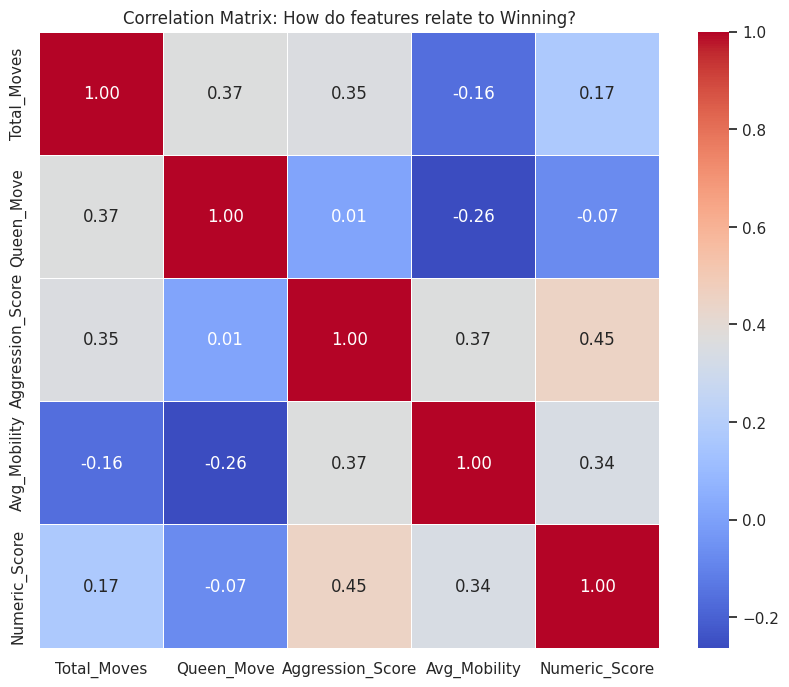

In [36]:
# Cell 3: Correlation Heatmap

# Select only the numerical columns we care about
numerical_cols = ['Total_Moves', 'Queen_Move', 'Aggression_Score', 'Avg_Mobility', 'Numeric_Score']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: How do features relate to Winning?")
plt.show()

/tmp/ipython-input-3495101558.py:8: FutureWarning: The provided callable <function mean at 0x79b70e14c220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(


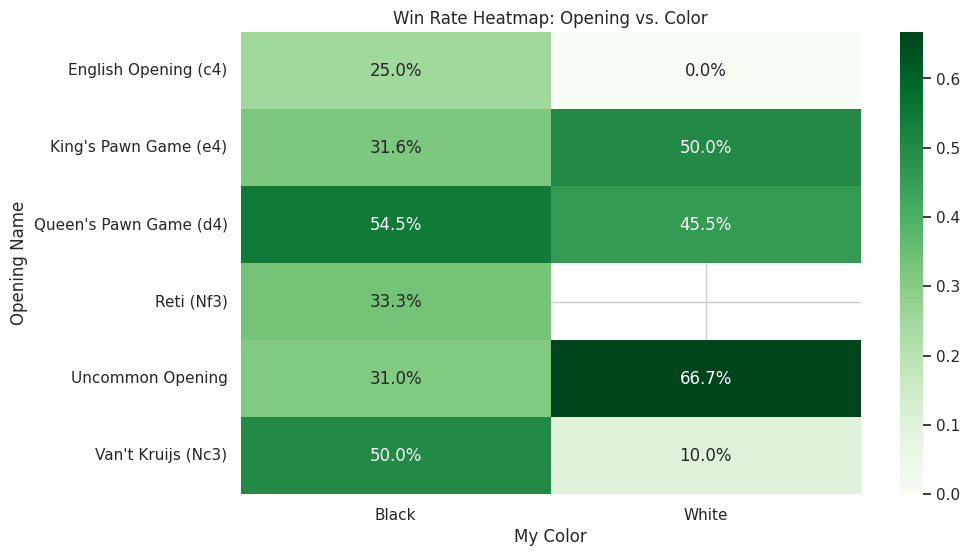

In [37]:
# Cell 4: Pivot Table & Heatmap (Openings)

# Filter for top 6 most common openings to keep the chart clean
top_openings = df['Opening'].value_counts().nlargest(6).index
subset_df = df[df['Opening'].isin(top_openings)]

# Create a Pivot Table: Rows=Opening, Cols=Color, Values=Win Rate
pivot_table = pd.pivot_table(
    subset_df,
    values='Numeric_Score',
    index='Opening',
    columns='My_Color',
    aggfunc=np.mean
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="Greens", fmt=".1%")
plt.title("Win Rate Heatmap: Opening vs. Color")
plt.ylabel("Opening Name")
plt.xlabel("My Color")
plt.show()

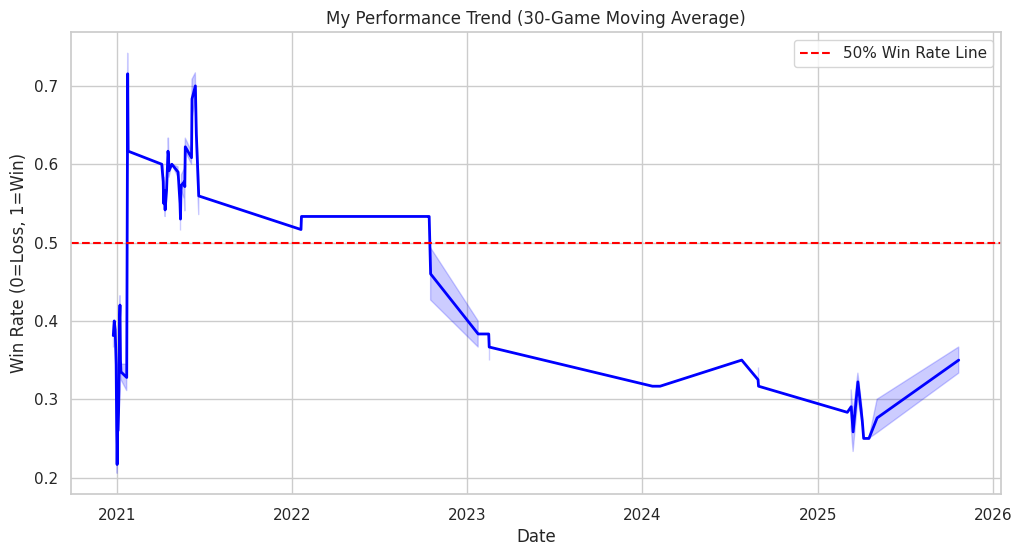

In [38]:
# Cell 5: Rolling Average (Learning Curve)

# Sort by date so time flows correctly
df = df.sort_values('Date')

# Calculate a 30-game Moving Average of my Score
# This smooths out lucky/unlucky streaks to show true skill
df['Rolling_Win_Rate'] = df['Numeric_Score'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Rolling_Win_Rate', data=df, color='blue', linewidth=2)
plt.title("My Performance Trend (30-Game Moving Average)")
plt.ylabel("Win Rate (0=Loss, 1=Win)")
plt.xlabel("Date")
plt.axhline(0.5, color='red', linestyle='--', label="50% Win Rate Line")
plt.legend()
plt.show()

/tmp/ipython-input-3939764554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='My_Result', y='Aggression_Score', data=df,


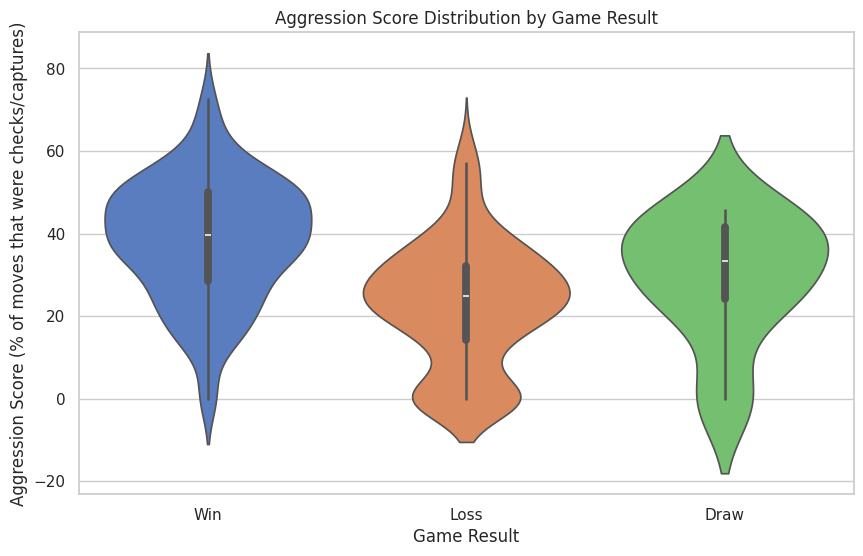

In [40]:
# Cell 6: Violin Plot - Aggression vs Result
# Research Question: Do I win more often when I play aggressively?

plt.figure(figsize=(10, 6))
sns.violinplot(x='My_Result', y='Aggression_Score', data=df,
               order=['Win', 'Loss', 'Draw'], palette="muted")
plt.title("Aggression Score Distribution by Game Result")
plt.xlabel("Game Result")
plt.ylabel("Aggression Score (% of moves that were checks/captures)")
plt.show()

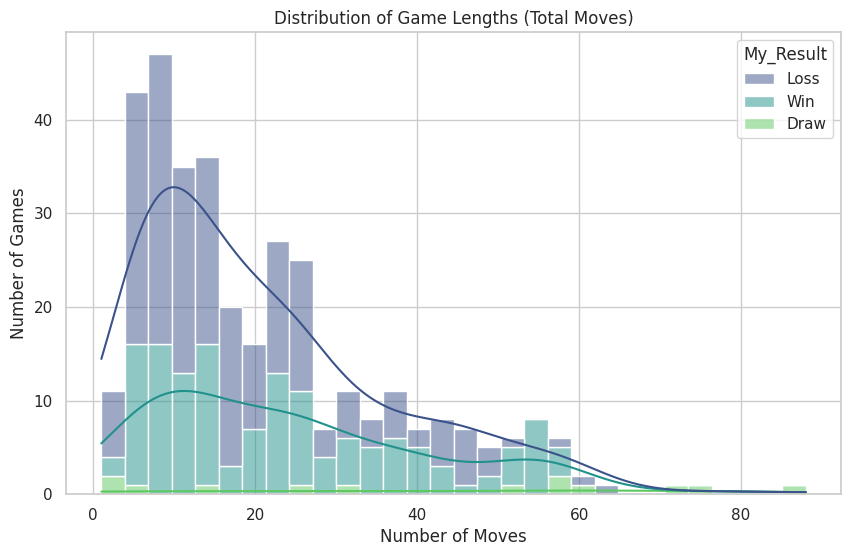

In [41]:
# Cell 7: Game Length Distribution
# Research Question: Do I tend to win short games or long games?

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Total_Moves', hue='My_Result',
             multiple="stack", bins=30, palette="viridis", kde=True)
plt.title("Distribution of Game Lengths (Total Moves)")
plt.xlabel("Number of Moves")
plt.ylabel("Number of Games")
plt.show()

/tmp/ipython-input-1319682343.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='My_Result', y='Queen_Move', data=queen_df,


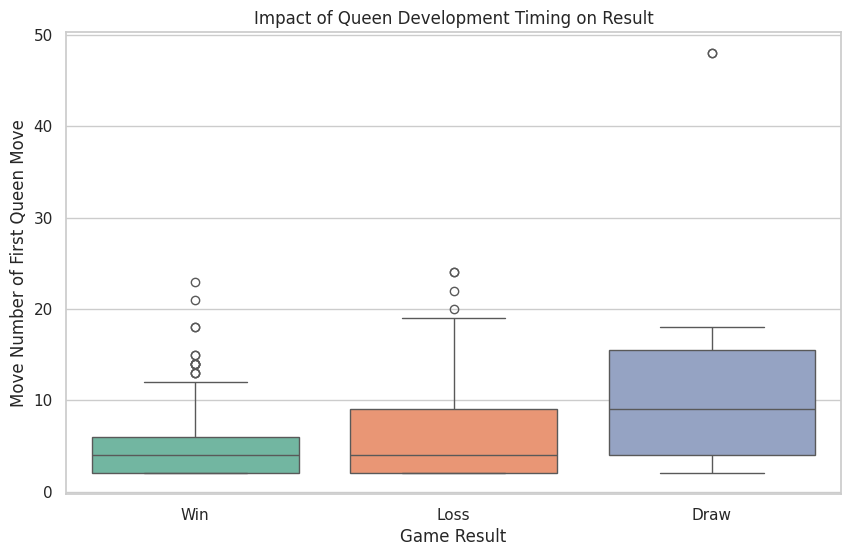

In [42]:
# Cell 8: Queen Development Timing
# Research Question: Does bringing the Queen out early hurt my chances?

plt.figure(figsize=(10, 6))
# Filter games where queen didn't move (NaN)
queen_df = df.dropna(subset=['Queen_Move'])

sns.boxplot(x='My_Result', y='Queen_Move', data=queen_df,
            order=['Win', 'Loss', 'Draw'], palette="Set2")
plt.title("Impact of Queen Development Timing on Result")
plt.xlabel("Game Result")
plt.ylabel("Move Number of First Queen Move")
plt.show()

/tmp/ipython-input-2922718208.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Game_Phase', y='Numeric_Score', data=phase_win_rates, palette="coolwarm")


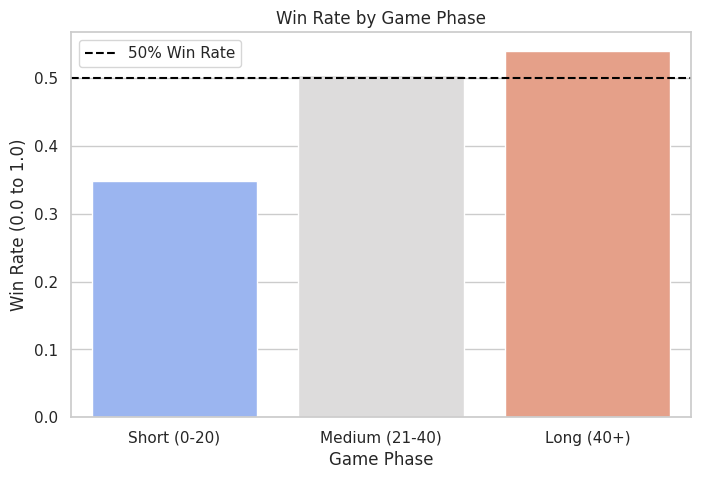

In [43]:
# Cell 9: Win Rate by Game Phase
# Research Question: Am I stronger in the opening or the endgame?

# Calculate average win rate (Numeric_Score) for each phase
phase_win_rates = df.groupby('Game_Phase', observed=False)['Numeric_Score'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Game_Phase', y='Numeric_Score', data=phase_win_rates, palette="coolwarm")
plt.title("Win Rate by Game Phase")
plt.xlabel("Game Phase")
plt.ylabel("Win Rate (0.0 to 1.0)")
plt.axhline(0.5, color='black', linestyle='--', label='50% Win Rate')
plt.legend()
plt.show()

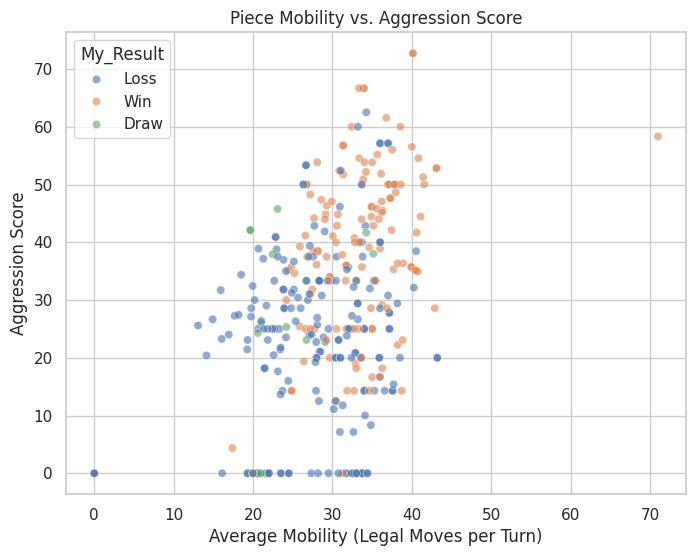

In [44]:
# Cell 10: Mobility vs Aggression Correlation
# Research Question: Does having more mobile pieces lead to more aggression?

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Avg_Mobility', y='Aggression_Score', hue='My_Result', alpha=0.6)
plt.title("Piece Mobility vs. Aggression Score")
plt.xlabel("Average Mobility (Legal Moves per Turn)")
plt.ylabel("Aggression Score")
plt.show()